In [10]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [11]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
from fuzzywuzzy import fuzz
import time


from bs4 import BeautifulSoup
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

import gc
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC , SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,log_loss

In [12]:
def boom1():
    beep = np.sin(2*np.pi*400*np.arange(10000*2)/10000)
    return ipd.Audio(beep, rate=10000, autoplay=True)

def boom2():
    audio_path="https://www.mfiles.co.uk/mp3-downloads/cherry-ripe.mp3"
    return ipd.Audio(audio_path, autoplay=True)

In [13]:
def s():
    print("="*50)

def ts():
    t_start = time.time()
    print("Time started...")
    s()
    s()
    return t_start

t_total = 0
def te(t1):
    t_end = time.time()
    t_time = t_end - t1
    s()
    s()
    global t_total
    t_total = t_total + t_time
    print("Time taken:",round(t_time, 4),"seconds.")
    s()
    print("Total Time:",round(t_total, 2),"seconds.")

In [14]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [15]:
# time start
t=ts()

Time started...


In [16]:
df_train = pd.read_csv('/kaggle/input/quora-question-pairs/train.csv.zip')
df_train.head()

# 0 = not duplicate; 1 = duplicate

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [18]:
df_train.shape

(404290, 6)

In [19]:
df_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [20]:
df_train.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [21]:
df_train[df_train.isnull().values]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [22]:
gone = [105780,201841,363362]

In [23]:
df_train = df_train.dropna()

print(df_train.shape)
df_train.head()

(404287, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [24]:
df_train.is_duplicate.value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [25]:
255024/len(df_train)*100

63.0799407351708

In [26]:
print('Percentage of questions is_not_duplicate or false: ', df_train.is_duplicate.value_counts()[0]/len(df_train)*100)
print('Percentage of questions is_duplicate or true: ', df_train.is_duplicate.value_counts()[1]/len(df_train)*100)

Percentage of questions is_not_duplicate or false:  63.0799407351708
Percentage of questions is_duplicate or true:  36.92005926482919


In [27]:
sum(df_train.duplicated(subset=['question1', 'question2']))
# print('percentage of duplicate data : ', (1827881/df_train.shape[0])*100, '%')
# df_train = df_train.drop_duplicates(['Title', 'Body', 'Tags'])
# df_train.head()

0

In [28]:
print('Number of unique rows in question1 columns: ', len(df_train['question1'].unique()))
print('Number of unique rows in question2 columns: ', len(df_train['question2'].unique()))
s()
print('Percentage of unique rows in question1 columns: ', len(df_train['question1'].unique())/len(df_train)*100)
print('Percentage of unique rows in question2 columns: ', len(df_train['question2'].unique())/len(df_train)*100)

Number of unique rows in question1 columns:  290455
Number of unique rows in question2 columns:  299173
Percentage of unique rows in question1 columns:  71.84376445445933
Percentage of unique rows in question2 columns:  74.00015335640275


Total number of question pairs for training: 404287
Total no. of unique question : 537929
Total no. of question repeated: 111778
Maximum time any question occurs : 157


Text(0, 0.5, 'Number of questions')

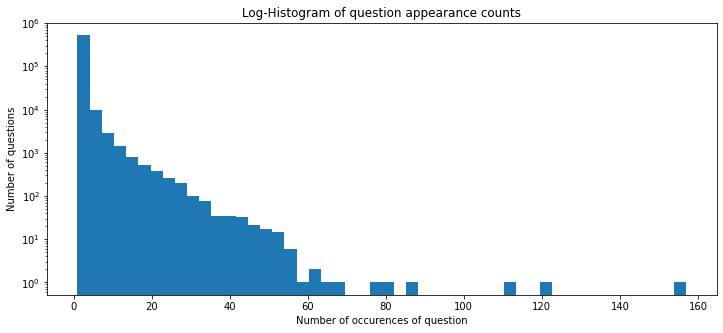

In [29]:
# based on id diffren. the how many questions are unique
qids = pd.Series(df_train.qid1.to_list() + df_train.qid2.to_list()) 
unique_questions = len(np.unique(qids)) 
no_repeat_qid = np.sum( qids.value_counts() > 1) # repeated

print('Total number of question pairs for training: {}'.format(len(df_train)))
print("Total no. of unique question :",unique_questions)
print("Total no. of question repeated:",no_repeat_qid)
print("Maximum time any question occurs :", np.max(qids.value_counts()))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

In [30]:
df_0 = df_train

In [31]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

df_test = pd.read_csv('/kaggle/input/quora-question-pairs/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
print(sub.shape)
sub.head()

Predicted score: 0.658528851473067
(2345796, 2)


,test_id,is_duplicate
0,0,0.369201
1,1,0.369201
2,2,0.369201
3,3,0.369201
4,4,0.369201


In [32]:
ls

X_train_transformed  __notebook_source__.ipynb  naive_submission.csv  y_label


3.3 Basic Feature Extraction (before cleaning) <br> 

Let us now construct a few features like: <br>

freq_qid1 = Frequency of qid1's <br>
freq_qid2 = Frequency of qid2's <br>
q1len = Length of q1 <br>
q2len = Length of q2 <br>
q1_n_words = Number of words in Question 1 <br>
q2_n_words = Number of words in Question 2 <br>
word_Common = (Number of common unique words in Question 1 and Question 2) <br>
word_Total =(Total num of words in Question 1 + Total num of words in Question 2) <br>
word_share = (word_common)/(word_Total) <br>
freq_q1+freq_q2 = sum total of frequency of qid1 and qid2 <br>
freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2 <br>

In [33]:
df_train['freq_qid1'] = df_train.groupby('qid1')['qid1'].transform('count') 
df_train['freq_qid2'] = df_train.groupby('qid2')['qid2'].transform('count')
df_train['q1len'] = df_train['question1'].str.len() 
df_train['q2len'] = df_train['question2'].str.len()
df_train['q1_n_words'] = df_train['question1'].apply(lambda row: len(row.split(" ")))
df_train['q2_n_words'] = df_train['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
df_train['word_Common'] = df_train.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df_train['word_Total'] = df_train.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df_train['word_share'] = df_train.apply(normalized_word_share, axis=1)

df_train['freq_q1+q2'] = df_train['freq_qid1']+df_train['freq_qid2']
df_train['freq_q1-q2'] = abs(df_train['freq_qid1']-df_train['freq_qid2'])

#df_train.to_csv("df_train_fe_without_preprocessing_train.csv", index=False)
print(df_train.shape)
df_train.head()

(404287, 17)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [40]:
ls

X_train_transformed  __notebook_source__.ipynb  naive_submission.csv  y_label


In [41]:
df = df_train
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


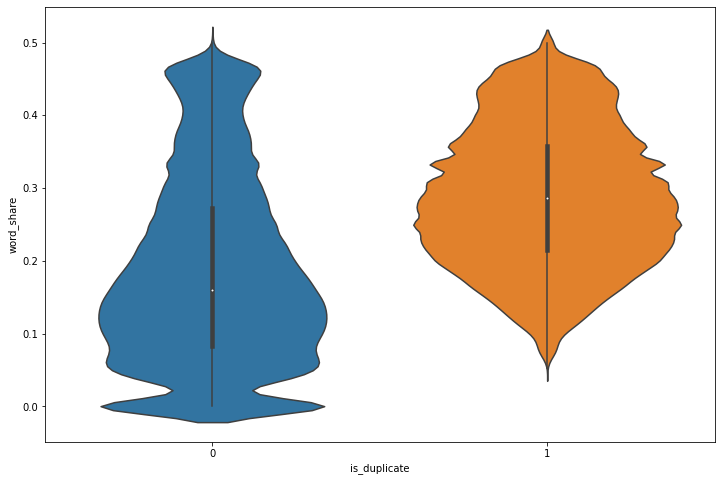

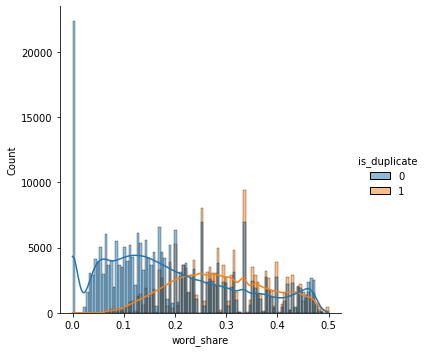

In [42]:
plt.figure(figsize=(12, 8))
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

sns.displot(data = df, x = df['word_share'], hue = df['is_duplicate'], kde=True)

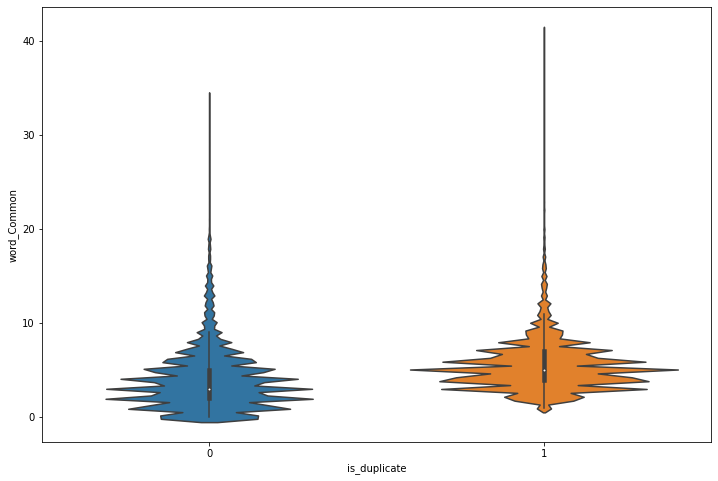

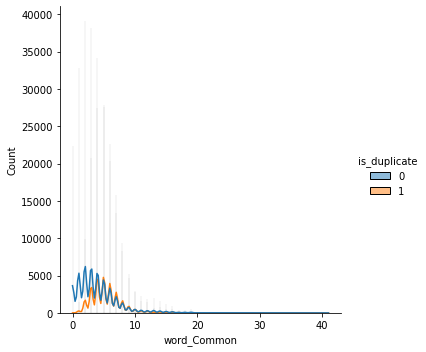

In [43]:
plt.figure(figsize=(12, 8))
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

sns.displot(data = df, x = df['word_Common'], hue = df['is_duplicate'], kde=True)

3.5 Advanced Feature Extraction (NLP and Fuzzy Features) <br>
Definition: <br>

Token: You get a token by splitting sentence a space <br>
Stop_Word : stop words as per NLTK. <br>
Word : A token that is not a stop_word <br>
Features: <br>

cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>
cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) <br>

cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>
cwc_max = common_word_count / (max(len(q1_words), len(q2_words)) <br>

csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br>
csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)) <br>

csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2 <br>
csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops)) <br>

ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2 <br>
ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens)) <br>


ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2 <br>
ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens)) <br>


last_word_eq : Check if First word of both questions is equal or not <br>
last_word_eq = int(q1_tokens[-1] == q2_tokens[-1]) <br>


first_word_eq : Check if First word of both questions is equal or not <br>
first_word_eq = int(q1_tokens[0] == q2_tokens[0]) <br>


abs_len_diff : Abs. length difference <br>
abs_len_diff = abs(len(q1_tokens) - len(q2_tokens)) <br>


mean_len : Average Token Length of both Questions <br>
mean_len = (len(q1_tokens) + len(q2_tokens))/2 <br>


fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ <br>


fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ <br>


token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ <br>

token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ <br>

longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2 <br>
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens)) <br>

In [44]:
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
       .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
       .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
       .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
       .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
       .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
       .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = SnowballStemmer(language= "english")
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [45]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

In [46]:
# get the Longest Common sub string

# def get_longest_substr_ratio(a, b):
#     strs = list(distance.lcsubstrings(a, b))
#     if len(strs) == 0:
#         return 0
#     else:
#         return len(strs[0]) / (min(len(a), len(b)) + 1)

In [47]:
def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].apply(preprocess)
    df["question2"] = df["question2"].apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    #df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [48]:
print("Extracting features for train:")
df = df_0
df = extract_features(df)
#df.to_csv("nlp_features_train.csv", index=False)
print(df.shape)
df.head()

Extracting features for train:
token features...
fuzzy features..
(404287, 31)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56


In [49]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio'],
      dtype='object')

In [50]:
df['id']

0              0
1              1
2              2
3              3
4              4
           ...  
404285    404285
404286    404286
404287    404287
404288    404288
404289    404289
Name: id, Length: 404287, dtype: int64

In [51]:
df.shape

(404287, 31)

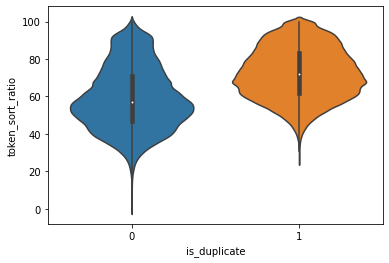

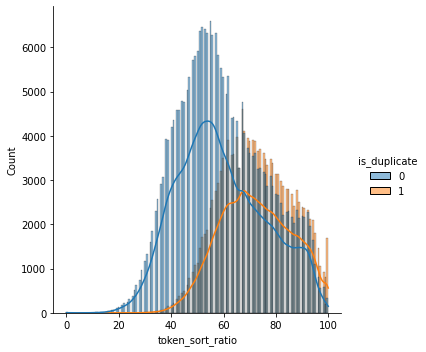

In [52]:
#plt.figure(figsize=(12, 8))
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:])

sns.displot(data = df, x = df['token_sort_ratio'], hue = df['is_duplicate'], kde=True)

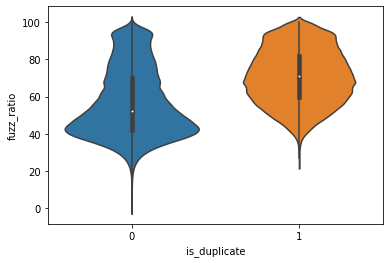

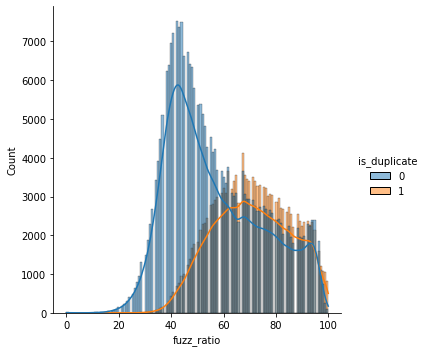

In [53]:
#plt.figure(figsize=(12, 8))
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:])

sns.displot(data = df, x = df['fuzz_ratio'], hue = df['is_duplicate'], kde=True)

In [54]:
tfidf = TfidfVectorizer() 
q1_vec = tfidf.fit_transform(df['question1'])
q2_vec = tfidf.fit_transform(df['question2'])

In [55]:
print(q1_vec.shape) 
print(q2_vec.shape) 

(404287, 68060)
(404287, 62869)


In [56]:
svd = TruncatedSVD(n_components = 200) # reduce dimension
q1_vec = svd.fit_transform(q1_vec)
q2_vec = svd.fit_transform(q2_vec)

In [57]:
len(q2_vec)

404287

In [58]:
# these are rows we deleted coz it had nan values.
gone

[105780, 201841, 363362]

In [59]:
id_num = []
for i in range(len(q1_vec)+3):
    if i == gone[0]:
        continue
    elif i == gone[1]:
        continue
    elif i == gone[2]:
        continue
    else: 
        id_num.append(i)

In [60]:
Xtrain1 = pd.DataFrame(q1_vec)
Xtrain1["id"] = id_num

Xtrain2 = pd.DataFrame(q2_vec)
Xtrain2["id"] = id_num

Xtrain = Xtrain1.merge(Xtrain2 , on = ['id'] , how = "left") # join the vectors

In [61]:
print(Xtrain.shape)
Xtrain.head()

(404287, 401)


,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,190_y,191_y,192_y,193_y,194_y,195_y,196_y,197_y,198_y,199_y
0,0.181553,-0.054569,-0.069366,0.000408,0.013046,0.021335,0.048553,-0.076476,-0.118794,0.031042,...,-0.007783,0.063936,-0.021352,-0.046842,-0.033212,0.089540,0.037343,-0.013507,-0.014952,-0.013479
1,0.115121,-0.073408,-0.004866,0.006203,0.073847,-0.007588,-0.034513,0.043744,0.008722,-0.027444,...,0.004768,-0.033783,-0.029035,0.010200,-0.025195,0.019346,-0.052541,-0.002776,-0.044510,-0.009791
2,0.142505,0.111508,-0.058586,-0.155759,0.096778,-0.007187,-0.054549,0.031467,0.074072,-0.070182,...,-0.006112,0.000618,0.001916,0.015272,-0.028006,-0.035533,0.056664,-0.017856,0.007270,0.027096
3,0.095955,0.142507,-0.065650,-0.021964,0.015143,0.101958,0.005203,-0.076172,0.055849,-0.004954,...,0.006935,0.008086,0.004862,0.000500,0.007516,0.007687,0.006859,0.002927,0.004884,0.011218
4,0.051126,-0.004682,-0.028159,-0.012439,0.025252,-0.003510,0.051505,-0.047968,-0.028235,0.038378,...,-0.014901,-0.098103,0.026115,-0.000706,-0.006667,-0.074845,-0.018570,0.025543,0.020727,-0.024764


In [62]:
Xtrain_all = df.merge(Xtrain , on = 'id' , how = "left") # join the vectors

In [63]:
print(Xtrain_all.shape)
Xtrain_all.head()

(404287, 431)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,190_y,191_y,192_y,193_y,194_y,195_y,196_y,197_y,198_y,199_y
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,-0.007783,0.063936,-0.021352,-0.046842,-0.033212,0.089540,0.037343,-0.013507,-0.014952,-0.013479
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.004768,-0.033783,-0.029035,0.010200,-0.025195,0.019346,-0.052541,-0.002776,-0.044510,-0.009791
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,-0.006112,0.000618,0.001916,0.015272,-0.028006,-0.035533,0.056664,-0.017856,0.007270,0.027096
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.006935,0.008086,0.004862,0.000500,0.007516,0.007687,0.006859,0.002927,0.004884,0.011218
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,-0.014901,-0.098103,0.026115,-0.000706,-0.006667,-0.074845,-0.018570,0.025543,0.020727,-0.024764


In [64]:
Xtrain_all[Xtrain_all.isna().values]

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,190_y,191_y,192_y,193_y,194_y,195_y,196_y,197_y,198_y,199_y


In [65]:
Xtrain_all.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       ...
       '190_y', '191_y', '192_y', '193_y', '194_y', '195_y', '196_y', '197_y',
       '198_y', '199_y'],
      dtype='object', length=431)

In [66]:
Xtrain_all.columns[:32]

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', '0_x'],
      dtype='object')

In [67]:
y_true = Xtrain_all['is_duplicate']

In [68]:
y_label = pd.DataFrame()
y_label['is_duplicate'] = y_true
print(y_label.shape)
y_label.head()

(404287, 1)


,is_duplicate
0,0
1,0
2,0
3,0
4,0


In [69]:
y_label.is_duplicate.value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [70]:
#y_label.to_csv("y_label", index=False)

In [71]:
#Xtrain_all.to_csv("X_train_all", index=False)

In [72]:
Xtrain_all.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1, inplace=True)

In [73]:
print(Xtrain_all.shape)
Xtrain_all.tail()

(404287, 425)


,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,190_y,191_y,192_y,193_y,194_y,195_y,196_y,197_y,198_y,199_y
404282,2,2,85,79,14,13,11.0,25.0,0.440000,4,...,0.004459,0.000165,-0.002946,-0.004147,0.003539,0.002882,-0.002723,0.003845,-0.001145,-0.003329
404283,12,1,41,42,8,9,5.0,16.0,0.312500,13,...,0.007366,-0.006829,0.002843,-0.012201,0.003989,-0.040472,0.013101,-0.003483,0.021528,0.009593
404284,1,1,17,17,4,3,1.0,7.0,0.142857,2,...,0.002201,-0.009222,-0.004725,-0.002759,0.000042,0.008490,0.002158,0.002171,-0.001699,-0.011846
404285,1,1,94,127,17,25,1.0,40.0,0.025000,2,...,-0.013040,-0.009793,0.035459,0.014631,-0.024433,0.027807,-0.005344,-0.025607,-0.009048,-0.013843
404286,1,1,37,45,8,10,8.0,18.0,0.444444,2,...,0.007631,-0.011317,-0.004411,0.018816,0.014074,0.004577,0.000199,-0.012865,-0.016209,-0.014967


In [74]:
Xtrain_all.columns[:31]

Index(['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', '0_x', '1_x', '2_x', '3_x', '4_x', '5_x'],
      dtype='object')

In [75]:
Scaler = StandardScaler()
Xtrain_trans = Scaler.fit_transform(Xtrain_all)

In [76]:
Xtrain_trans = pd.DataFrame(Xtrain_trans)
print(Xtrain_trans.shape)
Xtrain_trans.head()

(404287, 425)


,0,1,2,3,4,5,6,7,8,9,...,415,416,417,418,419,420,421,422,423,424
0,-0.407275,-0.33964,0.215861,-0.091795,0.562482,0.129116,1.771215,0.218073,1.647405,-0.426196,...,-0.318702,2.656523,-0.885807,-1.958018,-1.399031,3.770367,1.576858,-0.571635,-0.640815,-0.591884
1,0.261259,-0.33964,-0.285132,0.823644,-0.542098,0.287569,-0.165119,-0.131065,-0.182052,-0.096203,...,0.199418,-1.400068,-1.206175,0.425482,-1.063159,0.822947,-2.206364,-0.118803,-1.891680,-0.435126
2,-0.407275,-0.33964,0.449658,-0.032735,0.562482,-0.187790,-0.165119,0.334452,-0.441790,-0.426196,...,-0.249718,0.028040,0.084436,0.637430,-1.180928,-1.481360,2.390071,-0.755125,0.299612,1.132563
3,-0.407275,-0.33964,-0.318531,0.144447,0.010192,-0.346242,-1.456008,-0.247444,-1.740479,-0.426196,...,0.288861,0.338037,0.207281,0.020186,0.307202,0.333386,0.293778,0.121835,0.198630,0.457733
4,0.038415,-0.33964,0.549857,-0.623340,0.378385,-0.663148,-0.810563,-0.131065,-0.961265,-0.206201,...,-0.612549,-4.070162,1.093493,-0.030197,-0.286987,-3.132046,-0.776524,1.076143,0.869139,-1.071493


In [77]:
#Xtrain_trans.to_csv("X_train_transformed", index=False)

In [78]:
y_label

,is_duplicate
0,0
1,0
2,0
3,0
4,0
...,...
404282,0
404283,1
404284,0
404285,0


In [79]:
Xtrain_trans = pd.read_csv('./X_train_transformed')
Xtrain_trans.head()

,0,1,2,3,4,5,6,7,8,9,...,415,416,417,418,419,420,421,422,423,424
0,-0.407275,-0.33964,0.215861,-0.091795,0.562482,0.129116,1.771215,0.218073,1.647405,-0.426196,...,2.031446,-0.026454,-2.610244,-0.451783,2.144079,0.002009,-0.048027,-0.922188,0.750463,0.290841
1,0.261259,-0.33964,-0.285132,0.823644,-0.542098,0.287569,-0.165119,-0.131065,-0.182052,-0.096203,...,0.295000,-0.324219,-0.437265,-0.132063,0.351963,0.118012,-0.294533,-1.321983,-1.173805,1.853119
2,-0.407275,-0.33964,0.449658,-0.032735,0.562482,-0.187790,-0.165119,0.334452,-0.441790,-0.426196,...,-0.615996,1.558060,0.775652,0.377457,0.251890,1.376881,-0.848076,0.510573,-1.332750,-1.357556
3,-0.407275,-0.33964,-0.318531,0.144447,0.010192,-0.346242,-1.456008,-0.247444,-1.740479,-0.426196,...,-0.112959,0.350549,0.068892,0.019598,-0.307626,-0.153538,0.327114,0.176719,-0.227732,-0.201392
4,0.038415,-0.33964,0.549857,-0.623340,0.378385,-0.663148,-0.810563,-0.131065,-0.961265,-0.206201,...,1.875849,-0.075049,3.054135,-3.513226,-1.574752,3.329306,-3.169307,2.018204,-0.086338,-2.305228


In [80]:
Xtrain_trans.shape

(404287, 425)

In [81]:
y_label = pd.read_csv('./y_label')
y_label.head()

,is_duplicate
0,0
1,0
2,0
3,0
4,0


In [82]:
y_label.shape

(404287, 1)

In [83]:
X_train , X_test , Y_train , Y_test = train_test_split(Xtrain_trans, y_label)
print('done...')

done...


In [84]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(303215, 425) (303215, 1)
(101072, 425) (101072, 1)


In [85]:
model_accuracy = []
model_fm = []
model_log = []

In [2]:
print("Random max log-loss metric : " , log_loss(Y_test , np.random.randint(0,2,Y_test.shape)))

Random max log-loss metric :  17.25645289


In [86]:
model_rf = RandomForestClassifier(n_jobs=-1)
model_rf.fit(X_train,Y_train.values.ravel())
print('done...')

done...


In [87]:
#boom2()

In [88]:
y_pred = model_rf.predict(X_test)
x_pred = model_rf.predict(X_train)

print("Accuracy : " ,accuracy_score(Y_test , y_pred))
model_accuracy.append(accuracy_score(Y_test , y_pred))

print("f-measure : " ,f1_score(Y_test , y_pred))
model_fm.append(f1_score(Y_test , y_pred))

print("train log-loss : " , log_loss(Y_train , x_pred))
print("test log-loss : " , log_loss(Y_test , y_pred))
model_log.append(log_loss(Y_test , y_pred))

Accuracy :  0.8417662656324204
f-measure :  0.7777546170842539
train log-loss :  0.00034172824161886843
test log-loss :  5.465250628122734


In [89]:
model_lor = LogisticRegression(solver = 'sag', random_state =42 ,n_jobs=-1)
model_lor.fit(X_train,Y_train.values.ravel())
print('done...')

done...


In [90]:
#boom2()

In [91]:
y_pred = model_lor.predict(X_test)
x_pred = model_lor.predict(X_train)

print("Accuracy : " ,accuracy_score(Y_test , y_pred))
model_accuracy.append(accuracy_score(Y_test , y_pred))

print("f-measure : " ,f1_score(Y_test , y_pred))
model_fm.append(f1_score(Y_test , y_pred))

print("train log-loss : " , log_loss(Y_train , x_pred))
print("test log-loss : " , log_loss(Y_test , y_pred))
model_log.append(log_loss(Y_test , y_pred))

Accuracy :  0.8046442140256451
f-measure :  0.7200283587380362
train log-loss :  6.690022074445899
test log-loss :  6.747410029020402


In [92]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(use_label_encoder=False, n_jobs=-1)
xgbc.fit(X_train, Y_train.values.ravel())
print('done...')

[15:37:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
done...


In [93]:
y_pred = xgbc.predict(X_test)
x_pred = xgbc.predict(X_train)

print("Accuracy : " ,accuracy_score(Y_test , y_pred))
model_accuracy.append(accuracy_score(Y_test , y_pred))

print("f-measure : " ,f1_score(Y_test , y_pred))
model_fm.append(f1_score(Y_test , y_pred))

print("train log-loss : " , log_loss(Y_train , x_pred))
print("test log-loss : " , log_loss(Y_test , y_pred))
model_log.append(log_loss(Y_test , y_pred))

Accuracy :  0.8462482190913408
f-measure :  0.7879482560995579
train log-loss :  4.17775104498783
test log-loss :  5.310452881150158


In [94]:
model_log

[5.465250628122734, 6.747410029020402, 5.310452881150158]

In [2]:
print("Random max log-loss metric : " , log_loss(Y_test , np.random.randint(0,2,Y_test.shape)))

Random max log-loss metric :  17.25645289


In [95]:
# time end
te(t)

Time taken: 3050.4533 seconds.
Total Time: 3050.45 seconds.


In [96]:
boom2()